Dataset - [Bean Disease Dataset](https://www.kaggle.com/datasets/therealoise/bean-disease-dataset)

**Dataset Information**

The dataset was obtained from AI-Lab Makerere. The images were captured in bean fields by the Makerere AI lab in collaboration with the National Crops Resources Research Institute (NaCRRI), Uganda's national body in charge of agricultural research.

There are three classes in the dataset:

- Angular Leaf Spot
- Bean rust
- Healthy

# Importing required libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, pairwise_distances
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE, LocallyLinearEmbedding, MDS
import os
import cv2
from sklearn.decomposition import PCA
import matplotlib.image as mpimg
import random
from PIL import Image

from sklearn.metrics import pairwise_distances
from scipy.spatial import procrustes

### Apply PCA to the images from folder 'Bean_Dataset'. How many components do you need to preserve 95% of the variance?

In [3]:
import os
import cv2
import numpy as np

# Define the main folder
main_folder_path = 'bean_Dataset'

# List to store preprocessed image data
image_data = []
labels = []  # Using subfolder names as labels

subfolders = ['angular_leaf_spot', 'bean_rust', 'healthy']

for subfolder in subfolders:
    # Create the full path for the current subfolder
    current_folder_path = os.path.join(main_folder_path, subfolder)

    # Counter to keep track of the number of images processed for the current category
    images_processed = 0

    # Iterate through files in the current subfolder
    for filename in os.listdir(current_folder_path):

        # Assuming the files are images, you can add additional checks if needed
        if filename.endswith('.jpg'):
            # Create the full path for the current image
            current_image_path = os.path.join(current_folder_path, filename)

            # Load and preprocess the image in grayscale
            img = cv2.imread(current_image_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (64, 64))  # Resize the images to a consistent size
            image_data.append(img.flatten())

            # Append the label based on the subfolder
            labels.append(subfolder)

# Convert image_data and labels to NumPy arrays
image_data = np.array(image_data)
labels = np.array(labels)


 - The code resizes the image to a consistent size of 64x64 pixels using the 'cv2.resize' function. This step ensures uniformity in image dimensions, which can be beneficial for certain machine learning tasks.
 - Flattening converts the 2D image array into a 1D array, suitable for storing the pixel values of the image. The resulting image_data list is expected to contain flattened representations of all processed images in the specified directory.

 So, overall we process grayscale JPEG images in the specified directory, resize them to consistent size, flatten and then append the flattened representations to the 'image_data' list.

In [4]:
import numpy as np

# Convert image_data to a NumPy array
image_data = np.array(image_data)

# Check for NaN values
has_nan = np.any(np.isnan(image_data))
print("Any NaN values present:", has_nan)

# Print the shape of the array
print("Shape of image_data:", image_data.shape)

Any NaN values present: False
Shape of image_data: (990, 4096)


- Here the preprocessed image data is converted into a NumPy array. This transformation allows for efficient numerical operations and compatibility with various data manipulation.
- Secondly, here we have checked that the array contains any NaN values by using 'has_nan = np.isnan(image_data)'. We did this for ensuring that the data is in suitable format for further analysis.

In [5]:
#handle NaN values by mean imputation
if np.isnan(image_data).any():
    image_data[np.isnan(image_data)] = np.nanmean(image_data)

In [6]:
# Standarization (mean = 0, variance = 1)
mean = np.mean(image_data, axis=0)
std_dev = np.std(image_data, axis=0)
epsilon = 1e-10
std_dev[std_dev == 0] = epsilon
image_data = (image_data - mean) / std_dev

- Here, we standarizes the 'image_data' array by centering it around a mean of 0 and scaling it to have a variance of 1.
- For avoiding the divison by zero, a small epsilon value is also added to any standard deviation that is zero.
- Standardization is a common preprocessing step in machine learning to ensure that features have a consistent scale.

**Applying PCA and finding the number of Components required to preserve 95 % variance**

In [7]:
from sklearn.decomposition import PCA

# Assuming you want to preserve 95% of the variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(image_data)

print(f"Number of components to preserve 95% of variance: {pca.n_components_}")


Number of components to preserve 95% of variance: 595


The result implies that in our dataset a substantial amount of information is preserved even with a significantly reduced number of dimensions. Reducing the dimensionality can be beneficial for computational efficiency and may be particularly useful where we have a high number of features which can lead to increased complexity and computational cost.

### Plot 10 images of your choice in the original form (without PCA) and then plot their reconstruction (projection in the original space) after you kept 95% of variance using PCA

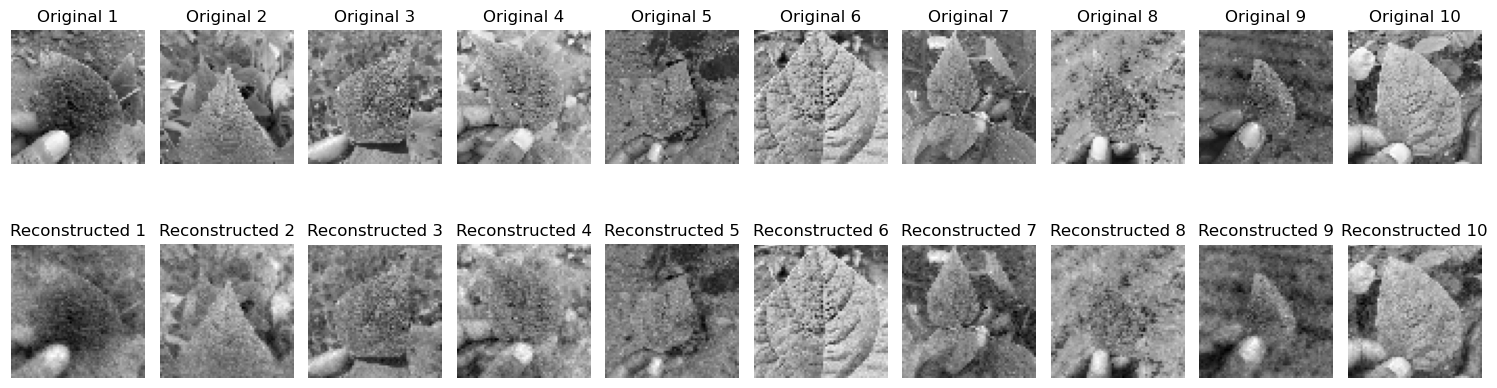

In [8]:
pca = PCA(n_components=0.95)
reduced_data = pca.fit_transform(image_data)
reconstructed_data = pca.inverse_transform(reduced_data)

# Randomly select 10 images for plotting
sample_indices = np.random.choice(reconstructed_data.shape[0], 10, replace=False)

# Plot the original and reconstructed images
plt.figure(figsize=(15, 5))
for i, idx in enumerate(sample_indices):
    # Original Image
    plt.subplot(2, 10, i+1)
    plt.imshow(image_data[idx].reshape(64, 64), cmap='gray')
    plt.axis('off')
    plt.title(f'Original {i+1}')
    # Reconstructed Image
    plt.subplot(2, 10, i+11)
    plt.imshow(reconstructed_data[idx].reshape(64, 64), cmap='gray')
    plt.axis('off')
    plt.title(f'Reconstructed {i+1}')
plt.tight_layout()
plt.show()

- In this part, using the PCA to reduce the dimensionality of set of images while retaining the 95% of the variance, we randomly selected 10 images and displayed them.
- This helped in visualizing the impact of PCA on image data, providing the insights into how well the reduced dimensional representation captures the essential information from the original images. So, here the output is an visual assesssment of the reduced dimensionality and information preservation in image data.

### Each of the images belongs to one of three bean disease categories.  We will now try to see if the visualization can help us identify different clusters.


#### Use PCA to reduce dimensionality to only 2 dimensions. How much of the variance is explained with the first two principal components?

In [9]:
#PCA to reduce dimensionality to 2 dimensions
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(image_data)
explained_variance_ratios = pca.explained_variance_ratio_         #explained variance ratios
for i, explained_variance_ratio in enumerate(explained_variance_ratios):
    print(f"Explained Variance for Principal Component {i+1}: {explained_variance_ratio*100:.2f}%")

Explained Variance for Principal Component 1: 20.82%
Explained Variance for Principal Component 2: 5.58%


- Here we have used PCA to reduce the dimensionality of the input data to 2 dimensions.
- Also found information about the percentage of variance explained by each of the two principal components.

#### Plot a 2D scatter plot of the images spanned by the first two principal components. Each image will be represented with a dot. Make the color of the dot correspond to the image category (so you will have three different colors).

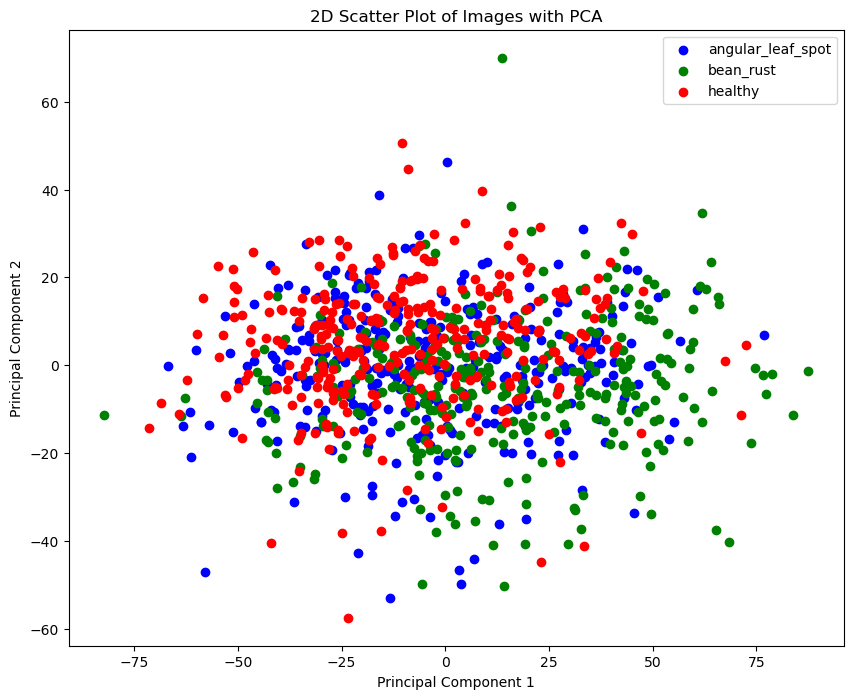

In [10]:
# Plot the 2D scatter plot
plt.figure(figsize=(10, 8))
unique_labels = np.unique(labels)

# Assuming you have assigned unique colors for each subfolder
colors = ['b', 'g', 'r']

for i, label in enumerate(unique_labels):
    label_indices = np.where(labels == label)
    plt.scatter(reduced_data[label_indices, 0], reduced_data[label_indices, 1], c=colors[i], label=f'{label}')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.title('2D Scatter Plot of Images with PCA')
plt.show()

 #### Then add some images to the visualization to better understand what features in the images are accounting for the majority of variance in the data. Repeat the process and create the same type of plots for t-SNE, LLE and MDS.

**Scatter Plots of Components with Images: t-SNE**

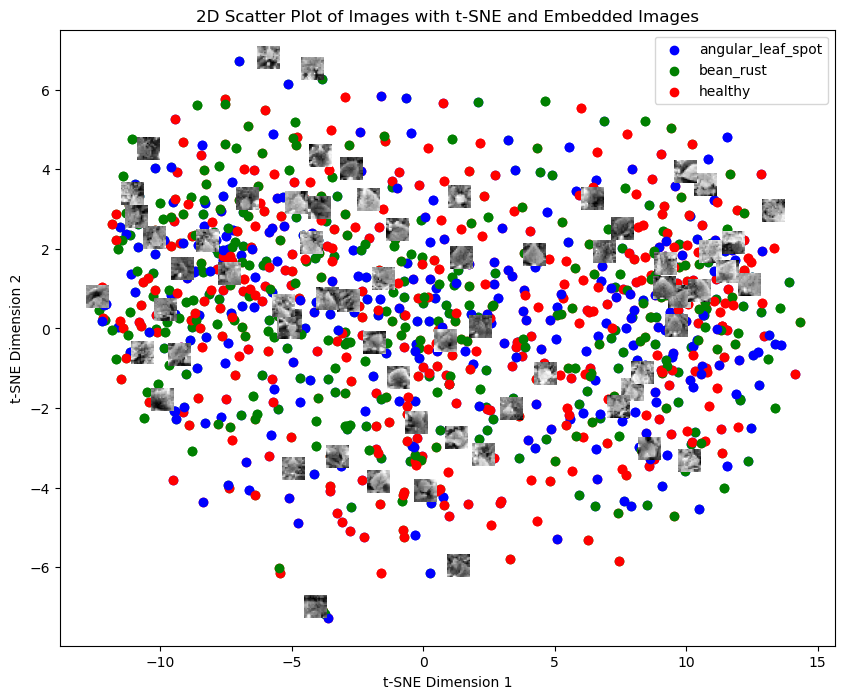

In [11]:
from matplotlib import offsetbox
from sklearn.manifold import TSNE


# Perform t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
reduced_data_tsne = tsne.fit_transform(image_data)

# Create a scatter plot
plt.figure(figsize=(10, 8))

# Assuming you have assigned unique colors for each category
colors = ['b', 'g', 'r']

unique_labels = np.unique(labels)

for i, label in enumerate(unique_labels):
    label_indices = np.where(labels == label)
    plt.scatter(reduced_data_tsne[label_indices, 0], reduced_data_tsne[label_indices, 1], c=colors[i], label=f'{label}')

# Selectively embed some images into the plot (resized to a small size)
for i in range(len(image_data)):
    # Condition to selectively embed only some images
    if i % 15 == 0:
        image = image_data[i].reshape(64, 64)  # Adjust the reshape size based on your image dimensions
        small_image = cv2.resize(image, (16, 16), interpolation=cv2.INTER_AREA)  # Resize to a smaller size

        # Create an AnnotationBbox for each small image
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(small_image, cmap='gray'),  # Use 'gray' for grayscale images
            (reduced_data_tsne[i, 0], reduced_data_tsne[i, 1]),  # Coordinates for the image
            boxcoords="data",
            frameon=False,
            pad=0.5,
        )
        plt.gca().add_artist(imagebox)
    else:
        # For non-embedded images, just plot dots
        plt.scatter(reduced_data_tsne[i, 0], reduced_data_tsne[i, 1], c=colors[i % len(colors)], marker='o')

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.title('2D Scatter Plot of Images with t-SNE and Embedded Images')
plt.show()


In this we visually represent t-SNE-transformed image data in a 2D scatter plot, distinguishing between different categories and selectively embedding resized bean disease images into the plot i.e, we replace some points of the plot with actual bean disease images to better understand what features in the images are accounting for the majority of variance in the data.

****Scatter Plots of Components with Images: LLE****

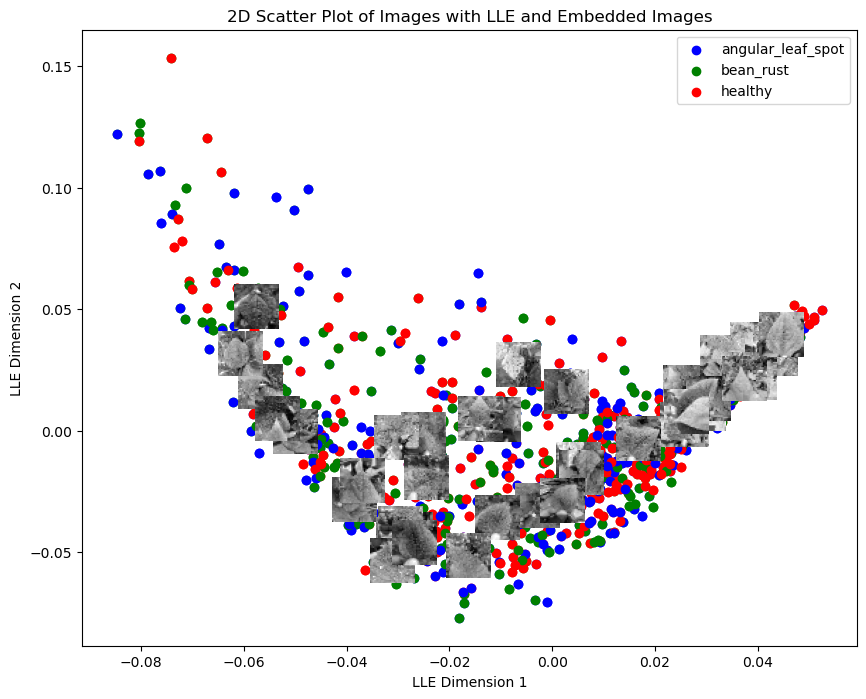

In [12]:
from sklearn.manifold import LocallyLinearEmbedding
from matplotlib import offsetbox

lle = LocallyLinearEmbedding(n_neighbors=30, n_components=2, method='standard')
reduced_data_lle = lle.fit_transform(image_data)

plt.figure(figsize=(10, 8))

# Assuming you have assigned unique colors for each category
colors = ['b', 'g', 'r']

unique_labels = np.unique(labels)

for i, label in enumerate(unique_labels):
    label_indices = np.where(labels == label)
    plt.scatter(reduced_data_lle[label_indices, 0], reduced_data_lle[label_indices, 1], c=colors[i], label=f'{label}')

# Selectively embed some images into the plot (resized to a small size)
for i in range(len(image_data)):
    # Condition to selectively embed only some images
    if i % 25 == 0:
        image = image_data[i].reshape(64, 64)
        small_image = cv2.resize(image, (32, 32), interpolation=cv2.INTER_AREA)

        # Create an AnnotationBbox for each small image
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(small_image, cmap='gray'),  # Use 'gray' for grayscale images
            (reduced_data_lle[i, 0], reduced_data_lle[i, 1]),  # Coordinates for the image
            boxcoords="data",
            frameon=False,
            pad=0.5,
        )
        plt.gca().add_artist(imagebox)
    else:
        # For non-embedded images, just plot dots
        plt.scatter(reduced_data_lle[i, 0], reduced_data_lle[i, 1], c=colors[i % len(colors)], marker='o')

plt.xlabel('LLE Dimension 1')
plt.ylabel('LLE Dimension 2')
plt.legend()
plt.title('2D Scatter Plot of Images with LLE and Embedded Images')
plt.show()


- We use Locally Linear Embedding (LLE) to reduce the dimensionality of image data to 2D and then create a scatter plot.
- Similarly we distinguished between different categories and selectively embedded resized bean disease images into the plot.

**Scatter Plots of Components with Images: MDS**

C:\Users\vatspari\AppData\Local\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


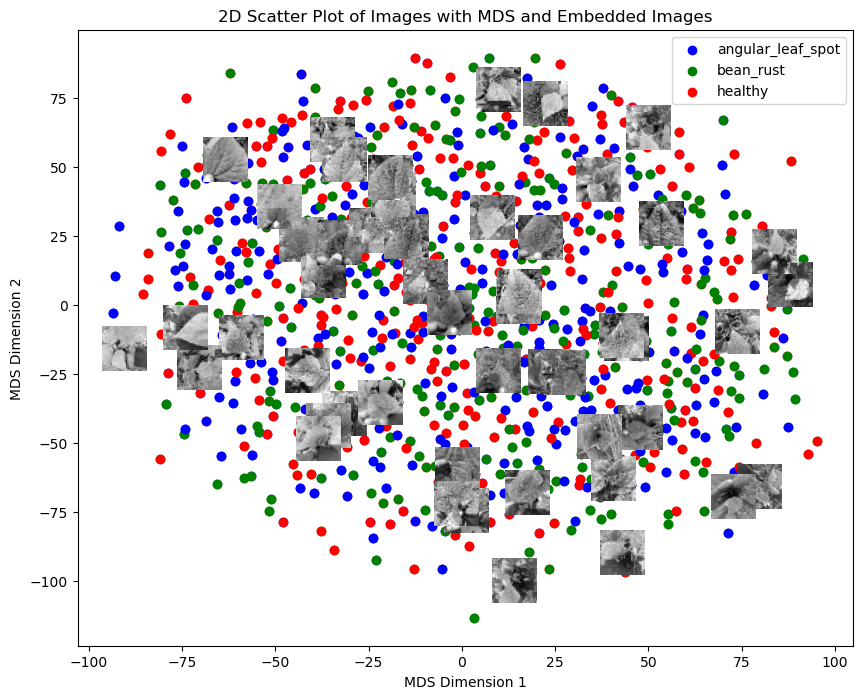

In [13]:
from sklearn.manifold import MDS

# Compute pairwise distance matrix using Euclidean distance
pairwise_distance_matrix = pairwise_distances(image_data, metric='euclidean')

mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)  # MDS model
reduced_data_mds = mds.fit_transform(pairwise_distance_matrix)

plt.figure(figsize=(10, 8))

colors = ['b', 'g', 'r']

unique_labels = np.unique(labels)

for i, label in enumerate(unique_labels):
    label_indices = np.where(labels == label)
    plt.scatter(reduced_data_mds[label_indices, 0], reduced_data_mds[label_indices, 1], c=colors[i], label=f'{label}')

# Selectively embed some images into the plot (resized to a small size)
for i in range(len(image_data)):
    # Condition to selectively embed only some images
    if i % 20 == 0:
        image = image_data[i].reshape(64, 64)
        small_image = cv2.resize(image, (32, 32), interpolation=cv2.INTER_AREA)

        # Create an AnnotationBbox for each small image
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(small_image, cmap='gray'),  # Use 'gray' for grayscale images
            (reduced_data_mds[i, 0], reduced_data_mds[i, 1]),  # Coordinates for the image
            boxcoords="data",
            frameon=False,
            pad=0.5,
        )
        plt.gca().add_artist(imagebox)
    else:
        # For non-embedded images, just plot dots
        plt.scatter(reduced_data_mds[i, 0], reduced_data_mds[i, 1], c=colors[i % len(colors)], marker='o')

plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.legend()
plt.title('2D Scatter Plot of Images with MDS and Embedded Images')
plt.show()


- Here we perform Multidimensional Scaling (MDS) on a pairwise distance matrix calculated using Euclidean distance and then create a 2D scatter plot to visualize the MDS-transformed data.

#### Which of the visualizations do you prefer?

**Discussion on the visualizations (preferred or not)**

**t-SNE (t-Distributed Stochastic Neighbor Embedding):**

- Tends to group similar instances together, emphasizing local similarities.
- Efficiently separates different types of bean diseases, showcasing clear visual distinctions between disease categories.
- Doesn't necessarily preserve the global structure of the data, but excels at revealing fine-grained local patterns in the distribution of diseases.

**LLE (Locally Linear Embedding):**

- Effectively preserves local relationships, making it adept at unfolding intricate patterns in the distribution of bean diseases.
- Successfully clusters bean disease images, providing a clear differentiation between various disease types and avoiding clutter.
-Sensitive to the choice of the number of neighbors, influencing the quality of the local linear approximations.

**MDS (Multi-Dimensional Scaling):**

- Preserves the global pairwise distances among bean disease instances, offering an overall view of the dataset's structure.
- However, there might not be a clear distinction among different diseases, especially when the dataset contains noise.
- Sensitivity to noise may impact the global representation of the dataset, but it remains useful for capturing overall relationships between instances.

**Which one to prefer?**
- Based on the observations, I think that LLE yields a better output than t-SNE and MDS because it distinguishes bean disease images well based on grayscale images, as we can see from the scatter plot.

### Cluster the images using K-Means.


#### To speed up the algorithm, use PCA to reduce the dimensionality of the dataset to two. Determine the number of clusters using one of the techniques we discussed in class.

**K-means is implemented correctly with the PCA reduced data set**

**Selection of the number of clusters using Silhouette Score**

C:\Users\vatspari\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\vatspari\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\vatspari\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\vatspari\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default valu

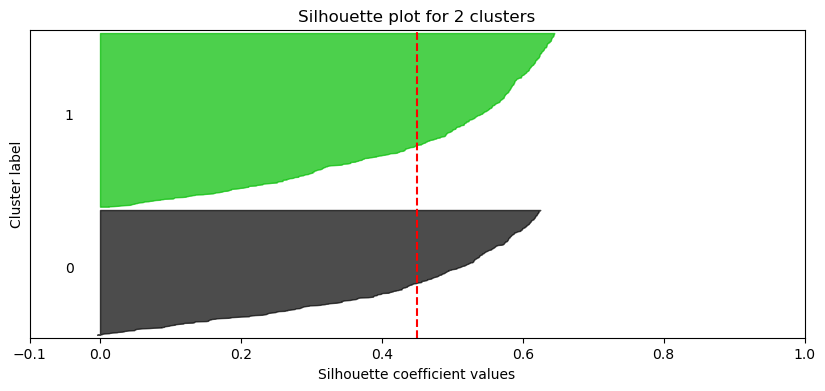

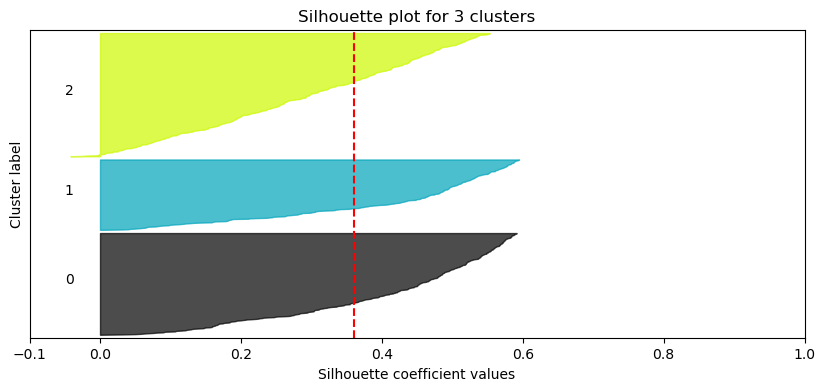

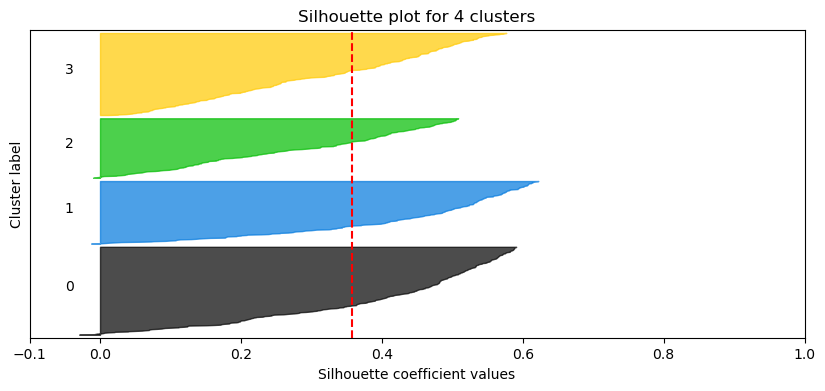

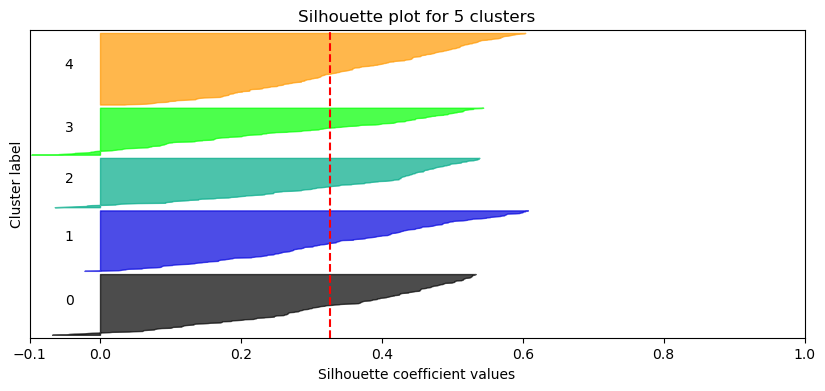

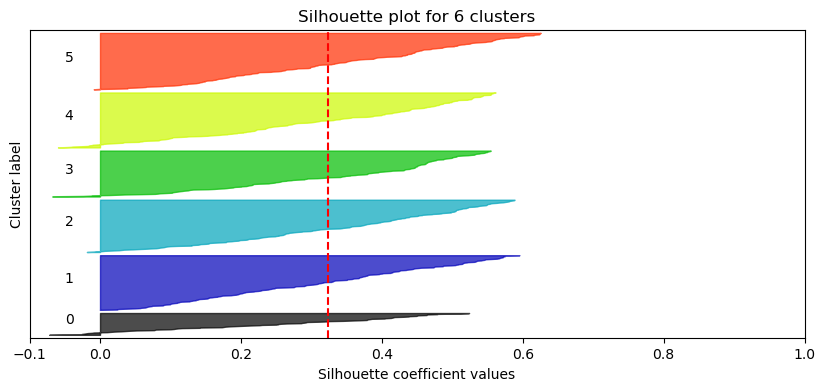

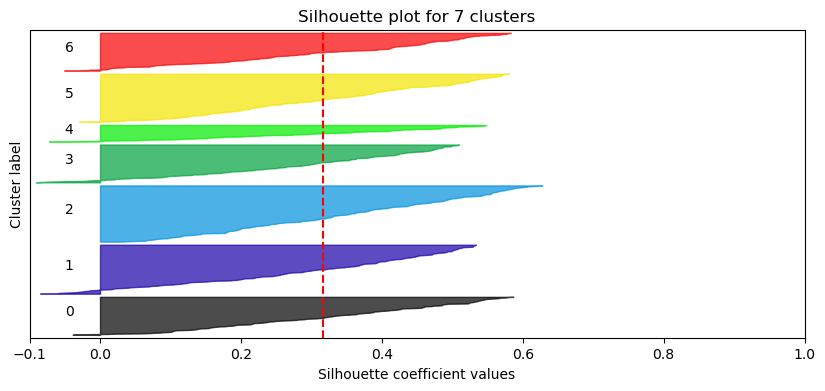

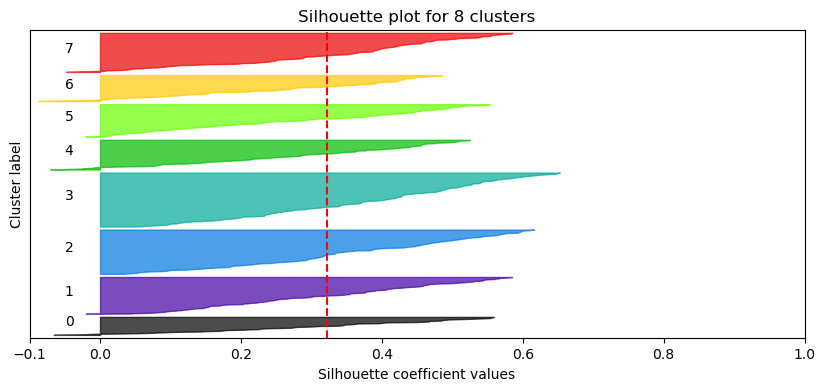

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Apply PCA to reduce dimensionality to 2 components
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(image_data)

# Determine the number of clusters using Silhouette Coefficient
silhouette_scores = []
possible_k_values = range(2, 9)

for k in possible_k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(reduced_data)
    silhouette_avg = silhouette_score(reduced_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(reduced_data, cluster_labels)

    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots()
    fig.set_size_inches(10, 4)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(reduced_data) + (k + 1) * 10])

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for the next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette plot for {} clusters".format(k))
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for the average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the y-axis labels/ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

- We do the silhouette analysis to determine the optimal number of clusters for KMeans clustering.
- It also applies PCA to reduce the dimensionality of the input data to 2 components.
- Then, it iterates over a range of cluster numbers (2 to 8), computes the silhouette score for each clustering, and generates silhouette plots for visual inspection.
- Silhouette plots display the silhouette coefficients for each sample, providing insight into the quality and separation of clusters. The red dashed line represents the average silhouette score, and the number of clusters with the highest silhouette score is considered optimal.
- It visualizes the silhouette plots for different cluster numbers to aid in choosing the appropriate cluster count.

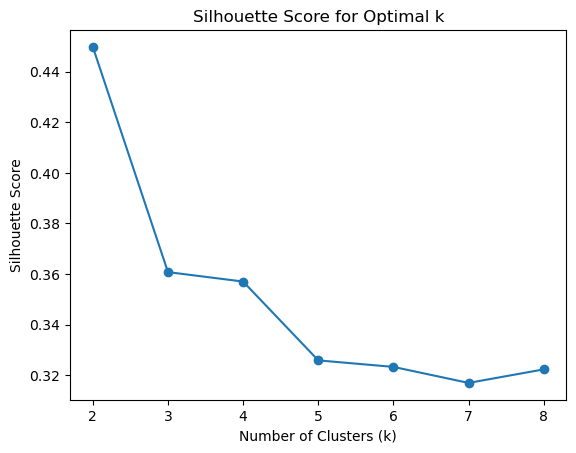

In [15]:
# Plot Silhouette Scores
plt.plot(possible_k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.show()

- We generate a line plot to visualize how the silhouette score changes with different numbers of clusters (k) in KMeans clustering. It uses the silhouette scores computed in the previous code block for each value of k.
- The plot helps in identifying the optimal number of clusters by looking for the value of k that maximizes the silhouette score. The peak in the plot indicates the number of clusters that provides the best separation and cohesion among data points.

**Observations made:**

1) It is observed that for k=2, we get an optimal Silhouette score, however in reality, we only have 3 classes for classifying bean diseases.

2) From the silhouette diagram, we can deduce that k=3 creates more dense clusters than k=2, inspite of a lower score. We use another method to determine the optimal k value.

**Selection of the number of clusters using Elbow method**

C:\Users\vatspari\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\vatspari\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\vatspari\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\vatspari\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default valu

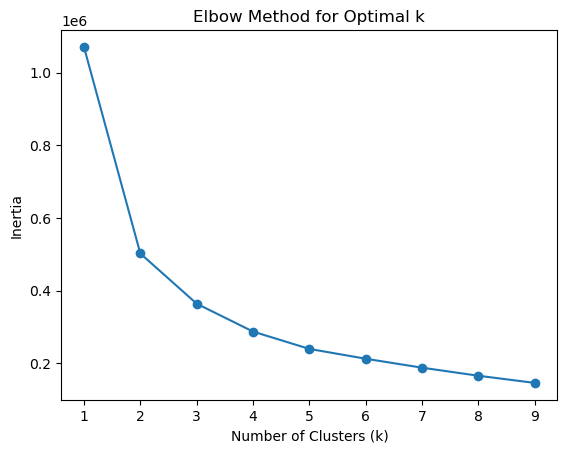

In [16]:
# Determine the number of clusters using the elbow method
inertia_values = []
possible_k_values = range(1, 10)

for k in possible_k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced_data)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(possible_k_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

- We implement the elbow method to determine the optimal number of clusters (k) for KMeans clustering.
- It calculates the inertia (within-cluster sum of squares) for different values of k and then plots the results.
- The "elbow" in the plot is typically considered the point where the inertia starts to decrease at a slower rate. The optimal number of clusters is often chosen at this elbow point as it indicates a good balance between minimizing intra-cluster distance and avoiding overfitting with too many clusters.

**Observations made:**

1) From the elbow method, we find that the line plot starts to decrease at a slower rate from k=3, which acts as the point where the inertia starts to decrease.

2) Hence, we take k=3 as the optimal method for computing clusters.

#### Visualize the clusters in a similar way to the visualization after line 28 here: https://github.com/ageron/handson-ml3/blob/main/09_unsupervised_learning.ipynb, but color each dot based on the clusters it belongs to using the labels.

**Visualization: Boundaries can be inferred with centroids of each cluster**

**Dots are color mapped according to labels**

C:\Users\vatspari\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


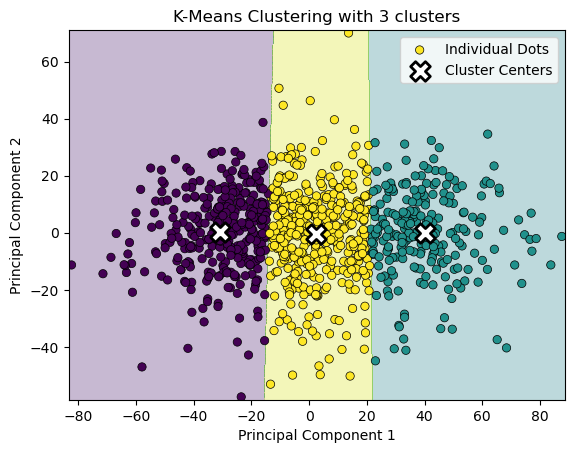

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensionality to 2 components
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(image_data)

# Perform K-Means clustering with the optimal k value
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(reduced_data)

# Visualize the clusters with decision boundaries
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Use contourf to color the insides of the decision boundaries
plt.contourf(xx, yy, Z, cmap='viridis', alpha=0.3)

# Scatter plot with individual data points colored by cluster
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='viridis', edgecolors='black', linewidth=0.5, label='Individual Dots')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='X', s=200, color='white', edgecolors='black', linewidth=2, label='Cluster Centers')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clustering with 3 clusters')
plt.legend()
plt.show()


- K-Means clustering is performed on the reduced 2D data obtained through Principal Component Analysis (PCA) and the number of clusters (k) is set to 3.
- After clustering, it visualizes the decision boundaries and individual data points in a scatter plot. The decision boundaries are shown using the contourf function, and each data point is colored based on its assigned cluster
- Additionally, the cluster centers are marked with white 'X' markers in the plot. The resulting visualization provides insight into how the data is partitioned into clusters by K-Means.

### Cluster the images using EM

#### Same as in the previous question, to speed up the algorithm, use PCA to reduce the dimensionality of the dataset to two. Determine the number of clusters using one of the techniques we discussed in class.

**EM has been implemented correctly**

**Evaluation for the number of clusters**

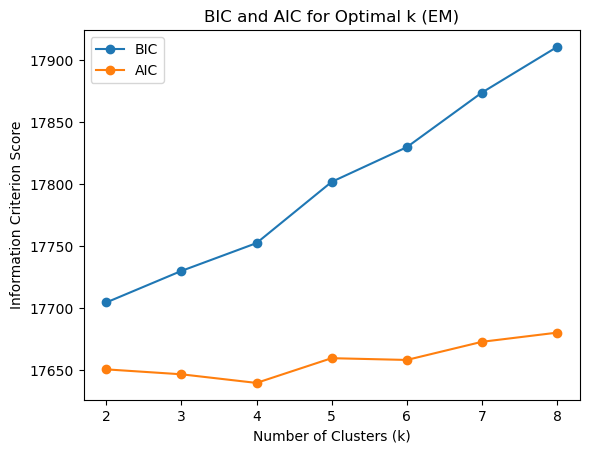

Optimal number of clusters (k) based on BIC: 2
Optimal number of clusters (k) based on AIC: 4
Final optimal number of clusters (k): 2


In [18]:
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Apply PCA to reduce dimensionality to 2 components
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(image_data)

# Determine the number of clusters using Bayesian Information Criterion (BIC) and Akaike Information Criterion (AIC)
bic_scores = []
aic_scores = []
possible_k_values = range(2, 9)

for k in possible_k_values:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(reduced_data)
    bic_scores.append(gmm.bic(reduced_data))
    aic_scores.append(gmm.aic(reduced_data))

# Plot BIC and AIC scores
plt.plot(possible_k_values, bic_scores, marker='o', label='BIC')
plt.plot(possible_k_values, aic_scores, marker='o', label='AIC')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Information Criterion Score')
plt.title('BIC and AIC for Optimal k (EM)')
plt.legend()
plt.show()

# Find the optimal k value based on minimum BIC and AIC
optimal_k_bic = possible_k_values[np.argmin(bic_scores)]
optimal_k_aic = possible_k_values[np.argmin(aic_scores)]

# Choose the optimal number of clusters based on the minimum of both BIC and AIC
optimal_k = min(optimal_k_bic, optimal_k_aic)

# Print out the optimal k value
print(f'Optimal number of clusters (k) based on BIC: {optimal_k_bic}')
print(f'Optimal number of clusters (k) based on AIC: {optimal_k_aic}')
print(f'Final optimal number of clusters (k): {optimal_k}')

# Perform EM clustering with the optimal k value
gmm = GaussianMixture(n_components=3, random_state=42)
cluster_labels = gmm.fit_predict(reduced_data)


- We determine the optimal number of clusters using both Bayesian Information Criterion (BIC) and Akaike Information Criterion (AIC).
- The BIC and AIC scores against the number of clusters (k) to visualize how these scores change with different cluster numbers.
- The final optimal number of clusters is determined as the minimum of both BIC and AIC.

**Observations made:**

1) It can be observed that through the BIC method we get the optimal k as 2, and through the AIC method we get the optimal k as 4.

2) Computing minimal score for both BIC and AIC, we finally determine the k value to be 2.

However, visually we find that the optimal number of clusters is 3. This may be due to the conversion of image into grayscale values.

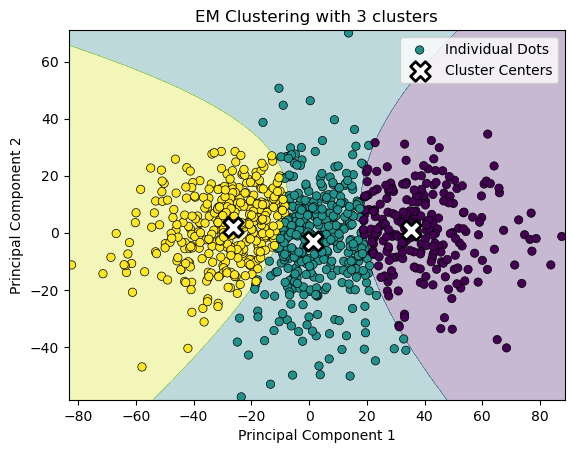

In [20]:
# Visualize the clusters with decision boundaries
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
Z = gmm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Use contourf to color the insides of the decision boundaries
plt.contourf(xx, yy, Z, cmap='viridis', alpha=0.3)

# Scatter plot with individual data points colored by cluster
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='viridis', edgecolors='black', linewidth=0.5, label='Individual Dots')
plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], marker='X', s=200, color='white', edgecolors='black', linewidth=2, label='Cluster Centers')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'EM Clustering with {3} clusters')
plt.legend()
plt.show()

- Gaussian Mixture Model is performed and the number of clusters (k) is set to 3.
- After clustering, it visualizes the decision boundaries and individual data points in a scatter plot. The decision boundaries are shown using the contourf function, and each data point is colored based on its assigned cluster.
- Additionally, the cluster centers are marked with white 'X' markers in the plot. The resulting visualization provides insight into how the data is partitioned into clusters by EM.

#### Use the model to generate 20 new rocks (using the sample( ) method), and visualize them in the original image space (since you used PCA, you will need to use its inverse_transform( ) method).

**Generation of 20 images using sample method with visualization**

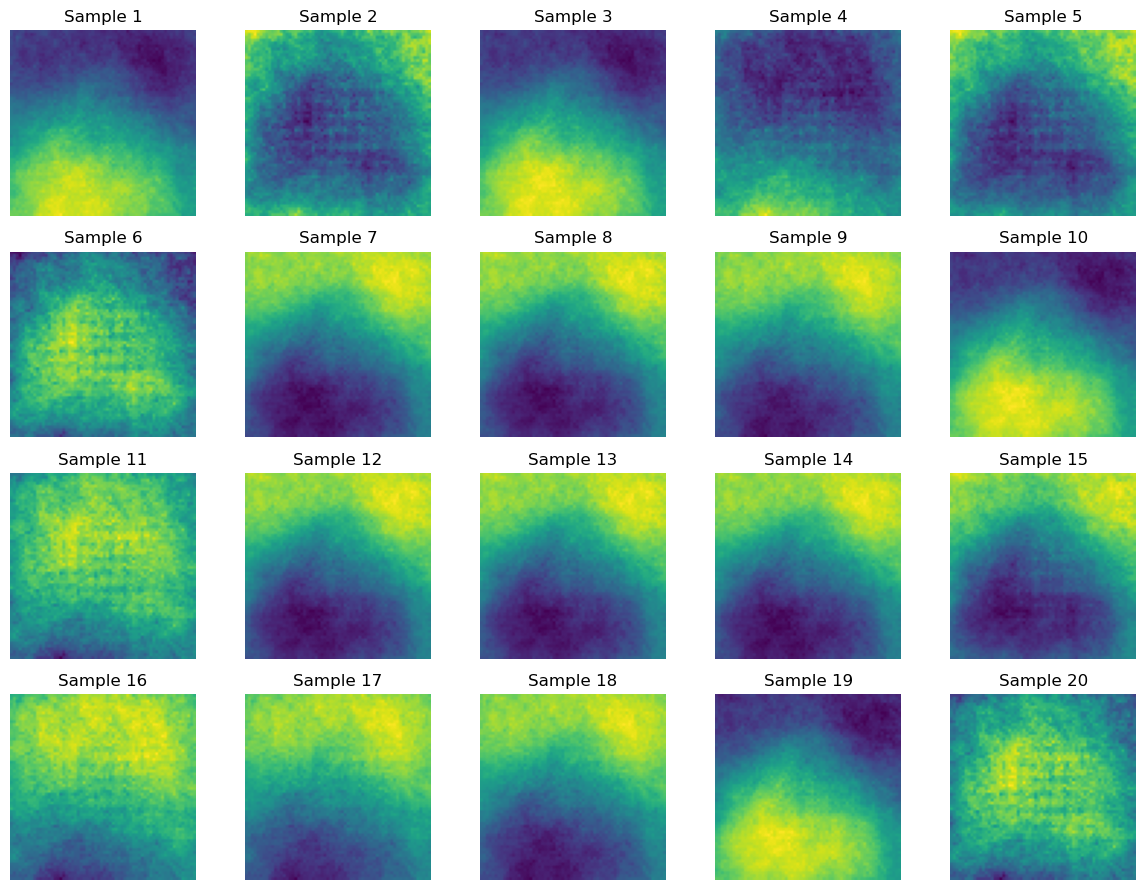

In [21]:
# Generate new samples from the GMM
n_samples = 20
generated_samples = gmm.sample(n_samples)  # This returns a tuple of generated samples and their component labels
generated_samples = generated_samples[0]  # Extract generated samples

# Use PCA's inverse_transform to map the samples back to the original space
original_samples = pca.inverse_transform(generated_samples)

# Visualize the generated samples in the original image space
fig, axes = plt.subplots(4, 5, figsize=(12, 9))
axes = axes.ravel()

for i in range(n_samples):
    image = original_samples[i].reshape(64, 64)
    axes[i].imshow(image)
    axes[i].set_title(f'Sample {i + 1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

- We visually inspect the quality and variety of samples generated by the GMM in the original image space.

- We assess how well the model has captured the underlying patterns in the data and can generate realistic-looking samples.

- The samples generated classify the rock images using GMM, and a clear distinction can be seen from dark gray scale and light bean images.

### Build a feedforward neural network (using dense and/or CNN layers) with a few hidden layers (we suggest using Keras (within Tensorflow) or Pytorch). Train the network to classify on some bean images using class as the label. Split the training data and use some images as your validation data. Choose the number of neurons you find appropriate and efficient (so you have enough time to run it), but make the last layer before the softmax should consist of 8 neurons. The hidden layers should have ReLU activation function. Train the network for multiple epochs until it converges (if the process is too slow, tweak the learning rate and consider simplifying your network).


In [23]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
import time
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Define the main folder containing subfolders H1, H2, H3, H5, and H6
main_folder_path = 'Bean_Dataset'

# List to store preprocessed image data
image_data = []
labels = []  # Using subfolder names as labels

# Iterate through subfolders angular_leaf_spot, bean_rust, healthy
subfolders = ['angular_leaf_spot', 'bean_rust', 'healthy']

# Iterate through subfolders
for subfolder in subfolders:
    # Create the full path for the current subfolder
    current_folder_path = os.path.join(main_folder_path, subfolder)

    # Iterate through files in the current subfolder
    for filename in os.listdir(current_folder_path):
        if filename.endswith('.jpg'):
            # Create the full path for the current image
            current_image_path = os.path.join(current_folder_path, filename)

            # Load and preprocess the image
            img = cv2.imread(current_image_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (64, 64))  # Resize the images to a consistent size
            image_data.append(img.flatten())

            # Append the label based on the subfolder
            labels.append(subfolder)

# Convert image_data and labels to NumPy arrays
image_data = np.array(image_data)
labels = np.array(labels)

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_one_hot = to_categorical(labels_encoded)

# Split the data into training and validation sets
train_image_data, val_image_data, train_labels_one_hot, val_labels_one_hot = train_test_split(
    image_data, labels_one_hot, test_size=0.2, random_state=42
)

# Standardize the data
train_image_data = (train_image_data - np.mean(train_image_data)) / np.std(train_image_data)
val_image_data = (val_image_data - np.mean(val_image_data)) / np.std(val_image_data)


- The code iterates through both the training and validation folders extracts the first letter of the filename as the label, and flattens the image data.

- We used Label encoding and one hot encoding for labelling the rock images.

- The image data is standardized (normalized) by subtracting the mean and dividing by the standard deviation separately for training and validation data to help in improving convergence during training.

**Sequential Model has been implemented correctly with right number of neurons**

In [24]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(64 * 64,), kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(8, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(3, activation='softmax'))

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

**The sequential model consists of the following:**

1) Input Layer: Dense layer with 256 neurons, ReLU activation function, and L2 regularization with a strength of 0.01.

2) Batch normalization layers follow each dense layer. Batch normalization helps stabilize and accelerate the training process.

3) Hidden Layer: Two additional dense layers with 128 and 64 neurons, respectively, both using ReLU activation functions.

4) Final Hidden Layer: A dense layer with 32 neurons and ReLU activation.

5) Output Layer: Dense layer with 3 neurons and softmax activation function.

6) Early stopping is implemented with a patience of 10 epochs. Training will stop if the validation loss does not improve for 10 consecutive epochs, and the best weights will be restored.

7) The model is compiled using the Adam optimizer, categorical crossentropy loss function, and accuracy as the metric to monitor during training.


#### Report the training time (use code to do this).

**Training Time has been Reported**

In [25]:
# Measure training time
start_time = time.time()

# Train the model
history = model.fit(train_image_data, train_labels_one_hot, epochs=30, batch_size=32, validation_data=(val_image_data, val_labels_one_hot), callbacks=[early_stopping])

# Calculate training time
training_time = time.time() - start_time
print(f"Training Time: {training_time} seconds")

Epoch 1/30


25/25 [==============================] - 3s 27ms/step - loss: 6.1319 - accuracy: 0.4078 - val_loss: 6.4354 - val_accuracy: 0.3889
Epoch 2/30
25/25 [==============================] - 0s 12ms/step - loss: 5.5221 - accuracy: 0.6225 - val_loss: 5.8336 - val_accuracy: 0.4293
Epoch 3/30
25/25 [==============================] - 0s 12ms/step - loss: 4.9128 - accuracy: 0.7210 - val_loss: 5.1378 - val_accuracy: 0.4949
Epoch 4/30
25/25 [==============================] - 0s 13ms/step - loss: 4.2702 - accuracy: 0.7841 - val_loss: 4.5725 - val_accuracy: 0.5253
Epoch 5/30
25/25 [==============================] - 0s 12ms/step - loss: 3.7160 - accuracy: 0.8131 - val_loss: 4.1302 - val_accuracy: 0.4848
Epoch 6/30
25/25 [==============================] - 0s 12ms/step - loss: 3.2009 - accuracy: 0.8561 - val_loss: 3.6139 - val_accuracy: 0.5051
Epoch 7/30
25/25 [==============================] - 0s 12ms/step - loss: 2.7819 - accuracy: 0.8788 - val_loss: 3.3478 - val_accuracy: 0.4697
Epoch 8/30


**The training time is reported using the print statement just below when the epochs are compiled.**

#### Plot training and validation loss and accuracy as a function of training epochs.


**Plots of val and training loss via training epochs**

Text(0.5, 1.0, 'Training and Validation Loss')

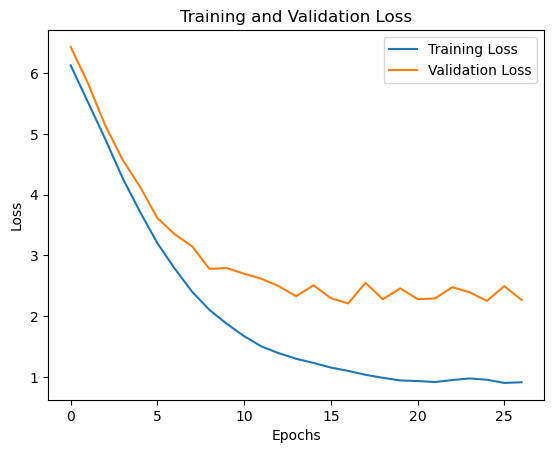

In [26]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

**Training Loss Curve:**

- The blue line represents the training loss at each epoch.
- This curve shows how well the model is fitting the training data.
- We observe a steady decrease in training loss over epochs.

**Validation Loss Curve:**


- The orange line represents the validation loss at each epoch.
- This curve reflects how well the model generalizes to unseen data.
- We observe a decrease in validation loss, indicating that the model is learning patterns that generalize well.

**Accuracy is increasing with epochs**

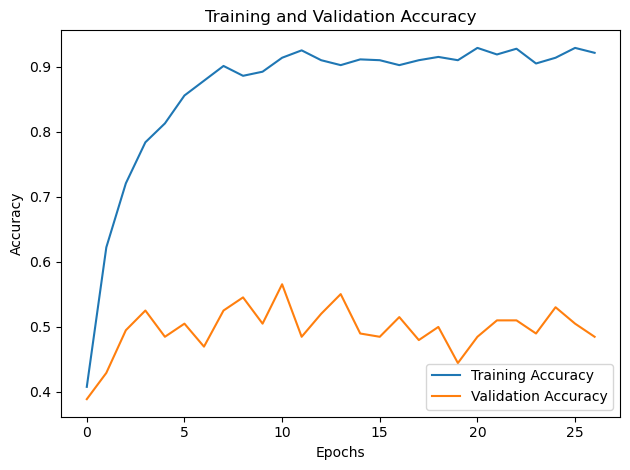

In [27]:
# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

**Training Accuracy Curve:**

- The blue line represents the training accuracy at each epoch.
- Training accuracy is the percentage of correctly classified samples in the training set.
- The accuracy increases over epochs, indicating improved performance.
- However, the training accuracy is significantly higher than validation accuracy, that suggests overfitting, where the model is too tailored to the training data.

**Validation Accuracy Curve:**

- The orange line represents the validation accuracy at each epoch.
- Validation accuracy is the percentage of correctly classified samples in the validation set, which consists of data that the model has not seen during training.
- The accuracy increases over epochs, indicating improved performance but also attains lows with increasing number of epochs, suggesting overfitting.

#### How many parameters does the network have? How many of those parameters are bias parameters?

**Total Number of parameters and Number of Bias Parameters**

In [28]:
# Count the total number of parameters
total_parameters = 0
for layer in model.layers:
    layer_parameters = np.sum([np.prod(weight.shape) for weight in layer.get_weights()])
    total_parameters += layer_parameters

print(f"Total parameters in the network: {total_parameters}")

# Count the number of bias parameters
bias_parameters = np.sum([np.prod(weight.shape) for weight in model.get_weights() if len(weight.shape) == 1])
print(f"Number of bias parameters: {bias_parameters}")

Total parameters in the network: 1094307
Number of bias parameters: 2443


**Number of training parameters**
- We iterate through each layer in the neural network.
- For each layer, we calculate the number of parameters by summing the product of the shapes of all weights in that layer using np.prod(weight.shape).
- The total number of parameters is accumulated in the total_parameters variable.

**Number of bias parameters**
- We count the number of bias parameters by summing the product of the shapes of all weights in the entire model where the length of the weight's shape is 1 (indicating bias).
- The result is stored in the bias_parameters variable.

**Future Work**

For the given problem of classifying bean diseases based on attributes, there are several avenues for future work:

1) Exploration of Additional Dimensionality Reduction Methods:

Investigate other dimensionality reduction techniques suitable for image data, such as UMAP (Uniform Manifold Approximation and Projection) or autoencoders. Compare their performance with t-SNE, LLE, and MDS.

2) Deep Learning Approaches:

Explore the use of deep learning models, such as convolutional neural networks (CNNs), for image classification tasks related to bean diseases. Train and evaluate these models to compare their performance with traditional dimensionality reduction techniques.

3) Transfer Learning:

Investigate the use of pre-trained models on related image datasets or domains to initialize and potentially improve the performance of your model on the bean disease dataset.